<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/res_dens_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)
il = ImageList.from_folder(path, convert_mode = 'L')
split = il.split_by_folder(train = 'training', valid = 'testing')
src = split.label_from_folder()
tfms = [[*rand_pad(padding= 3, size = 28, mode = 'zeros')], []]
ntfms = [[*rand_pad(padding = 3, size = 28, mode = 'reflection')]]
bs = 128
data = src.transform(tfms).databunch(bs = bs).normalize()

In [3]:
xb, yb = data.one_batch()

In [4]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [5]:
def conv(ni, nf, stride = 2, kernel_size = 3):
  return nn.Sequential(nn.Conv2d(ni, nf, stride = stride, kernel_size = kernel_size, padding = 1), 
                       nn.BatchNorm2d(nf), 
                       nn.ReLU())

def res_block(nf):
  return nn.Sequential(conv(nf, nf, stride = 1), conv(nf, nf, stride = 1))


In [ ]:
conv_layer = conv(1, 10)

res_layer = res_block(10)

In [ ]:
conv_2, conv_3 = conv(10, 10, stride = 1), conv(10, 10, stride = 1)

In [ ]:
params = []
for i in res_layer.parameters():
  params.append(i)
len(params)

8

In [ ]:
params[0].shape, params[4].shape

(torch.Size([10, 10, 3, 3]), torch.Size([10, 10, 3, 3]))

In [10]:
image = xb[0]
image.data.shape
image.data[None].shape
img_data = image.data[None]

In [ ]:
#testing
op = conv_layer(img_data);
op.shape

torch.Size([1, 10, 13, 13])

In [ ]:
inter_op = conv_2(op)
inter_op.shape

torch.Size([1, 10, 11, 11])

In [ ]:
test_layer = conv_layer(1, 10, stride=2)
test_res_1, test_res_2 = conv_layer(10, 10, stride = 1), conv_layer(10, 10, stride = 1)

In [ ]:
img_data.shape

torch.Size([1, 1, 28, 28])

In [ ]:
op = test_layer(img_data)
op.shape

torch.Size([1, 10, 14, 14])

In [ ]:
#step - 1 - get the op from first conv layer and store it in output variable
img_data = image.data[None]
conv_op = conv_layer(img_data)
print(conv_op.shape)
#step - 2 - Pass the output to res_block and store it in res_block_op variable
new_arch_op = res_layer(conv_op)
print(new_arch_op.shape)
#step - 3 - perform operations of resnet, by adding and store it in resnet variable
res_op = new_arch_op + conv_op
#step - 4 - perform operations of densnet, by concatenating and store it in dens net variable
dens_op = torch.cat([new_arch_op, conv_op], dim = 1)

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 14, 14])


In [ ]:
res_op.shape, dens_op.shape

(torch.Size([1, 10, 14, 14]), torch.Size([1, 20, 14, 14]))

In [7]:

class Block(nn.Module):
  def __init__(self, nf, is_dense = False, sub_delta = False):
    super().__init__()
    self.is_dense = is_dense
    self.sub_delta = sub_delta 
    self.l_1 = conv(nf, nf, stride = 1)
    self.l_2 = conv(nf, nf, stride = 1)
  
  def forward(self, xb):
    op = self.l_2(self.l_1(xb))
    if self.sub_delta:
      return op + (op - xb)
    return xb + op if not self.is_dense else torch.cat([xb, op], dim = 1)

In [11]:
x = Block(10, sub_delta = True)
c_layer = conv(1, 10)
op = c_layer(img_data)

In [14]:
op.shape
bop = x(op)
bop.shape

torch.Size([1, 10, 14, 14])

In [15]:
sub_arch = nn.Sequential(
    conv(1, 10), #10,14,14
    Block(10, sub_delta = True),#10, 14, 14
    conv(10, 24), #24, 7, 7
    Block(24, sub_delta = True),
    conv(24, 32), #32, 3, 3
    Block(32, sub_delta = True),
    conv(32, 10), #10, 1, 1,
    Block(10, sub_delta = True),
    Flatten()
)

In [16]:
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Test: None

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


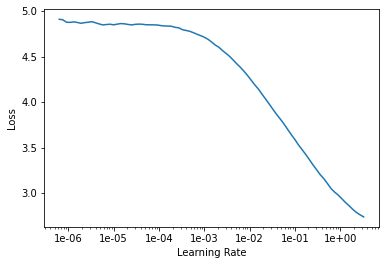

In [18]:
sub_learn = Learner(data, sub_arch, loss_func = nn.CrossEntropyLoss(), metrics = accuracy)
sub_learn.lr_find()
sub_learn.recorder.plot()

In [19]:
sub_learn.fit_one_cycle(4, max_lr = slice(3e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.179734,0.122286,0.966700,00:46
1,0.116630,0.083406,0.973900,00:45
2,0.054951,0.039130,0.987500,00:46
3,0.029889,0.020104,0.993200,00:46


In [ ]:
'''
def conv(ni, nf, stride = 2, kernel_size = 3):
  return nn.Sequential(nn.Conv2d(ni, nf, stride = stride, kernel_size = kernel_size, padding = 1), 
                       nn.BatchNorm2d(nf), 
                       nn.ReLU())
"""
class Block(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))
"""
'''
Block(10)

Block(
  (l_1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [ ]:
model = nn.Sequential(
    conv(1, 10), #10,14,14
    Block(10),#10, 14, 14
    conv(10, 24), #24, 7, 7
    Block(24),
    conv(24, 32), #32, 3, 3
    Block(32),
    conv(32, 10), #10, 1, 1,
    Block(10),
    Flatten()
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics = accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


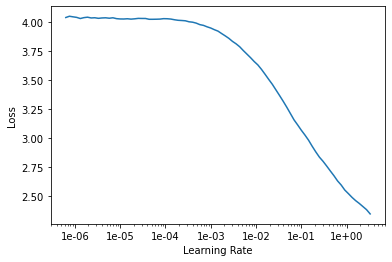

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr = slice(3e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.164388,0.116619,0.966000,00:29
1,0.081797,0.084908,0.973900,00:29
2,0.049309,0.038172,0.988000,00:29
3,0.029017,0.019162,0.994100,00:29


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


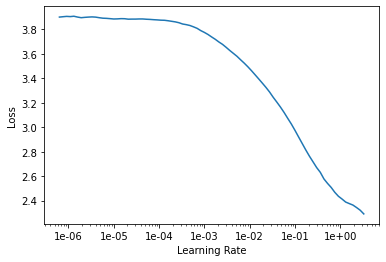

In [ ]:

dens_model = nn.Sequential(
  conv(1, 10),#10, 14, 14
  Block(10, True),#20, 14, 14
  conv(20, 32), # 32, 7, 7
  Block(32, True), #64, 7, 7
  conv(64, 32), # 32, 3, 3
  Block(32), #32, 3, 3
  conv(32, 10), #10, 1, 1
  Flatten()
)
res_dens_learn = Learner(data, dens_model, loss_func = nn.CrossEntropyLoss(), metrics = accuracy)
res_dens_learn.lr_find()
res_dens_learn.recorder.plot()

In [ ]:
res_dens_learn.fit_one_cycle(4, max_lr = slice(3e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.146008,0.659841,0.823000,00:28
1,0.091670,0.058197,0.982300,00:28
2,0.043457,0.032969,0.990100,00:28
3,0.023131,0.016709,0.994600,00:28
